In [ ]:
!pip install pyspark

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType, ArrayType
from pyspark.sql.functions import udf, lower, col, split, regexp_replace
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
import re
import nltk

In [ ]:
spark = SparkSession.builder.appName("Tweet Preprocessing and Sentiment Analysis").getOrCreate()
df = spark.read.csv('twitter_training.csv', header=True, sep=';')

In [ ]:
first_column_name = df.columns[0]
split_col = split(df[first_column_name], ',')
df = df.withColumn('ID', split_col.getItem(0)).withColumn('Topic', split_col.getItem(1)).withColumn('Sentiment', split_col.getItem(2)) \
       .withColumn('Text', split_col.getItem(3)).drop(first_column_name)

In [ ]:
df= df.limit(5000)

In [ ]:
df = df.dropna()
df = df.withColumn("text", lower(df["text"]))
df.show()

+----+-----------+---------+--------------------+
|  ID|      Topic|Sentiment|                text|
+----+-----------+---------+--------------------+
|2401|Borderlands| Positive|"i am coming to t...|
|2401|Borderlands| Positive|"im getting on bo...|
|2401|Borderlands| Positive|"im coming on bor...|
|2401|Borderlands| Positive|"im getting on bo...|
|2401|Borderlands| Positive|"im getting into ...|
|2402|Borderlands| Positive|so i spent a few ...|
|2402|Borderlands| Positive|"so i spent a cou...|
|2402|Borderlands| Positive|so i spent a few ...|
|2402|Borderlands| Positive|so i spent a few ...|
|2402|Borderlands| Positive|2010 so i spent a...|
|2402|Borderlands| Positive|                 was|
|2403|Borderlands|  Neutral|"rock-hard la var...|
|2403|Borderlands|  Neutral|"rock-hard la var...|
|2403|Borderlands|  Neutral|"rock-hard la var...|
|2403|Borderlands|  Neutral|  "rock-hard la vita|
|2403|Borderlands|  Neutral|"live rock - hard...|
|2403|Borderlands|  Neutral|     "i-hard like me|


In [ ]:
url_pattern = re.compile(r'http\S+')
df = df.withColumn("text", regexp_replace(df["text"],r"https?://\S+|www\.\S+",""))
df = df.withColumn("text", regexp_replace("text", r"@\S+", ""))
df=df.withColumn("text",regexp_replace(df["text"],r"[^\w\s,]",""))
df = df.withColumn("text", regexp_replace("text","[^0-9a-zA-Z_\-|]+:&.", " "))

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def remove_stopwords_and_tokenize(text):
    return [word for word in word_tokenize(text) if word.lower() not in stop_words]

df = df.withColumn("tokenized_column", udf(remove_stopwords_and_tokenize, ArrayType(StringType()))("text"))
df.show(truncate=False)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


+----+-----------+---------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|ID  |Topic      |Sentiment|text                                                                                                                                                                                                                                                                               |tokenized_column                                                                                                                                                                

In [ ]:
nltk.download('vader_lexicon')

def analyze_sentiment(text):
    from nltk.sentiment import SentimentIntensityAnalyzer

    sia = SentimentIntensityAnalyzer()
    sentiment = sia.polarity_scores(text)
    compound_score = sentiment['compound']

    if compound_score > 0:
        return 2
    elif compound_score < 0:
        return 1
    else:
        return 0

analyze_sentiment_udf = udf(analyze_sentiment, StringType())

df = df.withColumn('sentiment_score', analyze_sentiment_udf('text'))
df.select("text", "sentiment_score").show()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


+--------------------+---------------+
|                text|sentiment_score|
+--------------------+---------------+
|i am coming to th...|              1|
|im getting on bor...|              1|
|im coming on bord...|              1|
|im getting on bor...|              1|
|im getting into b...|              1|
|so i spent a few ...|              2|
|so i spent a coup...|              2|
|so i spent a few ...|              2|
|so i spent a few ...|              2|
|2010 so i spent a...|              2|
|                 was|              0|
| rockhard la varlope|              0|
| rockhard la varlope|              0|
| rockhard la varlope|              0|
|    rockhard la vita|              0|
|live rock  hard m...|              1|
|       ihard like me|              2|
|that was the firs...|              2|
|this was the firs...|              1|
|that was the firs...|              2|
+--------------------+---------------+
only showing top 20 rows



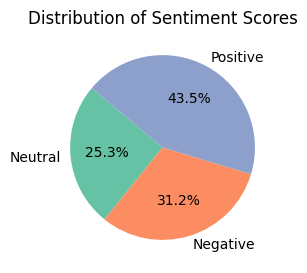

In [ ]:
labels = ['Neutral', 'Negative', 'Positive']
sentiment_counts = df.groupBy('sentiment_score').count().orderBy('sentiment_score').collect()

counts = [row['count'] for row in sentiment_counts]
colors = ['#66c2a5', '#fc8d62', '#8da0cb']

plt.figure(figsize=(3, 3))
plt.pie(counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Sentiment Scores')
plt.show()